In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import os.path
import skimage
import skimage.segmentation
import sklearn.preprocessing
import sklearn.model_selection
import math
import glob
import uuid
import pathlib
import random
import platform
import torch
import torchvision
import numpy as np
import scipy as sp
import scipy.io
import scipy.signal
import pandas as pd
import networkx
import cv2
import wfdb
import json
import tqdm
import dill
import pickle
import matplotlib.pyplot as plt

from scipy.stats import norm
from scipy.stats import lognorm, norm, halfnorm

import src.data
import sak
import sak
import sak.visualization
import sak.visualization.plot
import sak.signal.wavelet
import sak.data
import sak.data.augmentation
import sak.data.preprocessing
import sak.visualization
import sak.visualization.plot
import sak.torch
import sak.torch.nn
import sak.torch.nn as nn
import sak.torch.nn
import sak.torch.train
import sak.torch.data
import sak.torch.models
import sak.torch.models.lego
import sak.torch.models.variational
import sak.torch.models.classification

from sak.signal import StandardHeader

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

def moving_amplitude(x, w):
    return [np.max(x[i:i+w])-np.min(x[i:i+w]) for i in range(0,len(x),w)]

def moving_operation(x, w, operation):
    return [operation(x[i:i+w]) for i in range(0,len(x),w)]

def predict_mask(signal, N, stride, model, ptg_voting = 0.25):
    total_samples = np.zeros((1,),dtype='int64')
    
    # Data structure for computing the segmentation
    windowed_signal = np.array([(skimage.util.view_as_windows((signal)[:,lead],N,stride)) for lead in range(signal.shape[1])])[:,:,None,:]
    windowed_sample = np.array((skimage.util.view_as_windows(np.arange(signal.shape[0]),N,stride)))

    segmentation = np.zeros((3,signal.shape[0]),dtype=int)
    samples_voting = np.zeros((signal.shape[0],),dtype=int)

    # Compute segmentation for all leads independently
    for lead in range(windowed_signal.shape[0]):
        for i in range(0,windowed_signal.shape[1]):
            with torch.no_grad():
                prediction = predict_segment(model,windowed_signal[lead,i,None,...]) > thr_dice
#                 prediction = predict_segment(model,{"x": windowed_signal[lead,i,None,...]})["sigmoid"] > thr_dice

            # Fused segmentation
            segmentation[:,windowed_sample[i]] += prediction
            samples_voting[windowed_sample[i]] += 1

    # Keep track of number of samples predicted
    total_samples += samples_voting.sum()

    # Majority voting according to number of times windowed and computed
    segmentation = (segmentation > (samples_voting*ptg_voting).astype(int))
    
    return segmentation

def predict_segment(model, input):
    input = {"x": torch.tensor(input).cuda().float()}
    output = model(input)["sigmoid"][0].cpu().detach().numpy().squeeze()
#     return model(torch.tensor(input).cuda().float())[0].cpu().detach().numpy().squeeze()
    return output

In [3]:
basedir = '/home/guille/DADES/DADES/HCMPatients/'
fs = 500.

In [4]:
config_file = './configurations/UNet7LevelsConvDiceOnly.json'

with open(config_file, 'r') as f:
    execution = json.load(f)

mname = 'UNet7LevelsConvDiceOnly_20201203124825'
    
# Define model
# model = torch.load('/media/guille/DADES/DADES/Delineator/TrainedModels/relativeampl_MultiUNet5_0/fold_1/relativeampl_MultiUNet5_0/model_best.model',pickle_module=dill).eval().float()
# model = torch.load('/media/guille/DADES/DADES/Delineator/TrainedModels/relativeampl_uNet5_3/fold_1/relativeampl_uNet5_3/model_best.model',pickle_module=dill).eval().float()
# model = torch.load('/media/guille/DADES/DADES/Delineator/TrainedModels/relativeampl_uNet5_2/model_best.model',pickle_module=dill).eval().float()
# model = torch.load('/media/guille/DADES/DADES/Delineator/TrainedModels/relativeampl_uNet5_0/model_best.model',pickle_module=dill).eval().float()
# model = torch.load('/media/guille/DADES/DADES/Delineator/TrainedModels/relativeampl_uNet5_0/checkpoint.model',pickle_module=dill).eval().float()
# model = torch.load('/home/guille/GitHub/DelineatorSwitchAndCompose/models/modelo5nivsdice.state',pickle_module=dill).eval().float()
# model = torch.load(os.path.join(execution['save_directory'],mname,'model_best.model'),pickle_module=dill).eval().float()
model = []
for path in [os.path.join(os.path.expanduser(execution['save_directory']),mname,"fold_{}".format(i+1),'model_best.model') for i in range(5)]:
    model.append(torch.load(path,pickle_module=dill).eval().float())

100%|██████████| 153/153 [10:39<00:00,  4.18s/it]


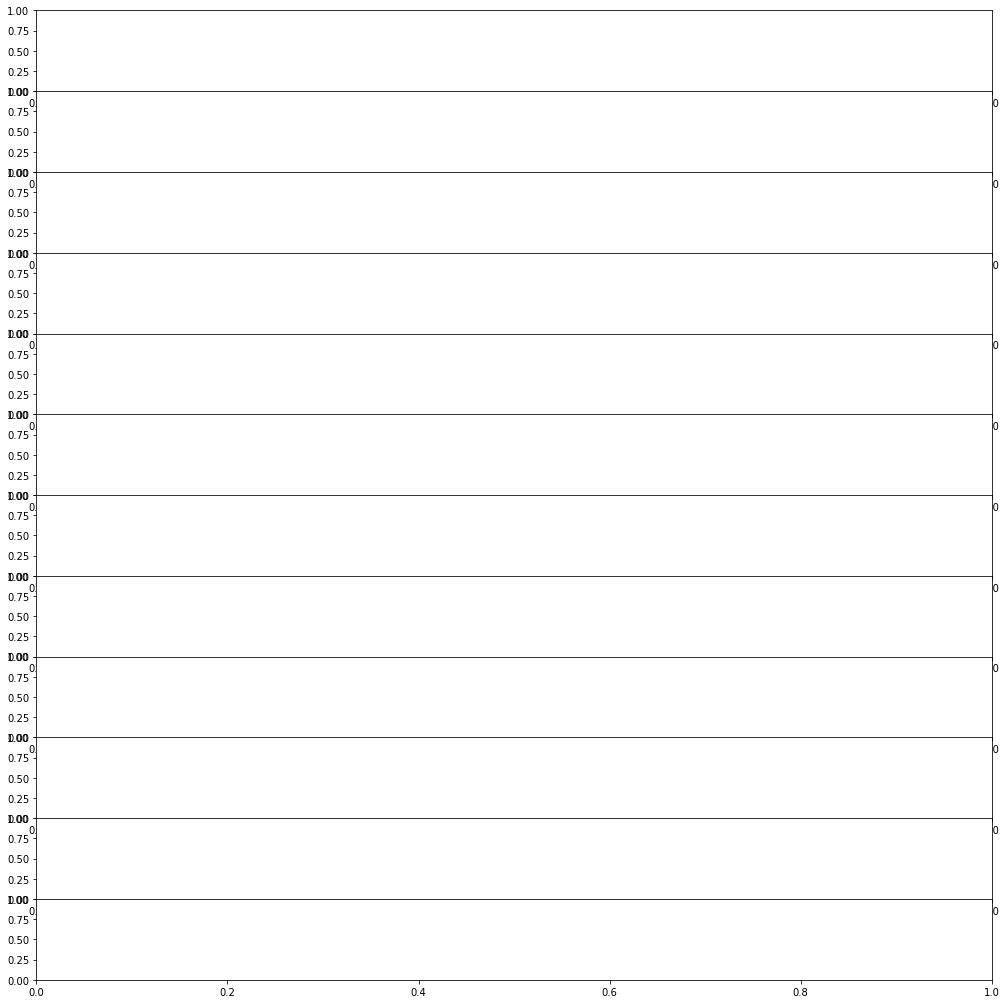

In [20]:
N = 2048
L = 12
stride = 128
thr_dice = 0.8
ptg_voting = 0.5

# Output folder
out_folder = f'/home/guille/Escritorio/HCM/{mname}'
if not os.path.isdir(out_folder):
    pathlib.Path(out_folder).mkdir(parents=True, exist_ok=True)
if not os.path.isdir(os.path.join(out_folder,'HCM_Patients')):
    pathlib.Path(os.path.join(out_folder,'HCM_Patients')).mkdir(parents=True, exist_ok=True)
if not os.path.isdir(os.path.join(out_folder,'HCM_Relatives')):
    pathlib.Path(os.path.join(out_folder,'HCM_Relatives')).mkdir(parents=True, exist_ok=True)

# Plot
f,ax = plt.subplots(nrows=12, figsize=(14,14))

# Characteristics
Ponsets  = {}
Poffsets = {}
QRSonsets  = {}
QRSoffsets = {}
Tonsets  = {}
Toffsets = {}

# Iterate over files
files  = []
files += glob.glob(os.path.join(basedir,'HCM_Patients','*.csv'))
files += glob.glob(os.path.join(basedir,'HCM_Relatives','*.csv'))

for file in tqdm.tqdm(files):
#     if "CPH-MCH10" not in file:
#         continue
        
    signal = pd.read_csv(file)
    root,fname = os.path.split(file)
    fname, ext = os.path.splitext(fname)
    patient_type = os.path.split(root)[1]
    
    # Downsample signal
    down_factor = int(fs//250)
    signal = sp.signal.decimate(signal,down_factor,axis=0)
    
    # Compute moving operation for matching amplitude criteria to development set
    ampl = np.median(moving_operation(signal,200,lambda x: np.max(x,axis=0)-np.min(x,axis=0)),axis=0)
#     ampl = np.median(moving_operation(signal,200,sak.signal.abs_max),axis=0)

    # Pad signal for inputing in algorithm
    if signal.shape[0] < N:
        signal = np.pad(signal,((0,math.ceil(signal.shape[0]/N)*N-signal.shape[0]),(0,0)),mode='edge')
    if (signal.shape[0]-N)%stride != 0:
        signal = np.pad(signal,((0,math.ceil((signal.shape[0]-N)/stride)*stride-(signal.shape[0]%N)),(0,0)),mode='edge')
    
    # Correct amplitudes
    signal = signal/ampl
    
    # Filter high frequency noise
    signal_original = np.copy(signal)
    signal = sp.signal.filtfilt(*sp.signal.butter(4, 75.0/250.,  'low'),signal.T).T

    # Obtain segmentation
    if isinstance(model, list):
        for i,m in enumerate(model):
            if i == 0:
                segmentation = predict_mask(signal, N, stride, m, ptg_voting).astype(int)
            else:
                segmentation += predict_mask(signal, N, stride, m, ptg_voting)
                
        segmentation = segmentation >= 3
    else:
        segmentation = predict_mask(signal, N, stride, model, ptg_voting)
    
    # Morphological operations
    p               = cv2.morphologyEx(segmentation[0,:].astype('float32'), cv2.MORPH_CLOSE, np.ones((5,))).squeeze()
    qrs             = cv2.morphologyEx(segmentation[1,:].astype('float32'), cv2.MORPH_CLOSE, np.ones((5,))).squeeze()
    t               = cv2.morphologyEx(segmentation[2,:].astype('float32'), cv2.MORPH_CLOSE, np.ones((5,))).squeeze()
    segmentation[0,:] = cv2.morphologyEx(p,   cv2.MORPH_OPEN,  np.ones((5,))).squeeze().astype(bool)
    segmentation[1,:] = cv2.morphologyEx(qrs, cv2.MORPH_OPEN,  np.ones((5,))).squeeze().astype(bool)
    segmentation[2,:] = cv2.morphologyEx(t,   cv2.MORPH_OPEN,  np.ones((5,))).squeeze().astype(bool)
        
    # Obtain onsets/offsets
    pon,poff = sak.signal.get_mask_boundary(segmentation[0,:])
    qrson,qrsoff = sak.signal.get_mask_boundary(segmentation[1,:])
    ton,toff = sak.signal.get_mask_boundary(segmentation[2,:])
    
    # Save stuff
    Ponsets[fname] = (np.array(pon)*down_factor).tolist()
    Poffsets[fname] = (np.array(poff)*down_factor).tolist()
    QRSonsets[fname] = (np.array(qrson)*down_factor).tolist()
    QRSoffsets[fname] = (np.array(qrsoff)*down_factor).tolist()
    Tonsets[fname] = (np.array(ton)*down_factor).tolist()
    Toffsets[fname] = (np.array(toff)*down_factor).tolist()
    
    # Plot
    [ax[i].plot(signal_original[:,i]) for i in range(L)]
    [ax[i].set_xlim([0,signal.shape[0]]) for i in range(L)]
    [[ax[i].axvspan(pon[j],poff[j], linewidth=0, alpha=0.15, color='red') for j,_ in enumerate(pon)] for i in range(L)]
    [[ax[i].axvspan(qrson[j],qrsoff[j], linewidth=0, alpha=0.15, color='green') for j,_ in enumerate(qrson)] for i in range(L)]
    [[ax[i].axvspan(ton[j],toff[j], linewidth=0, alpha=0.15, color='magenta') for j,_ in enumerate(ton)] for i in range(L)]
    f.tight_layout()
    f.subplots_adjust(hspace=0.00,wspace=0.05)
    f.savefig(os.path.join(out_folder,f"{patient_type}",f"{mname}_{fname}.png"))
    [ax[i].clear() for i in range(L)]

sak.save_data(  Ponsets,  os.path.join(out_folder,  'Ponsets.csv'))
sak.save_data(  Poffsets, os.path.join(out_folder,  'Poffsets.csv'))
sak.save_data(QRSonsets,  os.path.join(out_folder,'QRSonsets.csv'))
sak.save_data(QRSoffsets, os.path.join(out_folder,'QRSoffsets.csv'))
sak.save_data(  Tonsets,  os.path.join(out_folder,  'Tonsets.csv'))
sak.save_data(  Toffsets, os.path.join(out_folder,  'Toffsets.csv'))
